In [1]:
from src import UDP_RX, SlidingBook, MACChecker
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sys

def ProMAC_X(M, x):
    # Initialize an NxN matrix with zeros
    matrix = np.zeros((M, M), dtype=int)
    
    # Populate the matrix
    for i in range(M):
        # Determine the start position for the ones in the current row
        start_pos = i % M
        for j in range(x):
            col_pos = (start_pos + j) 
            if col_pos >= M:
                continue
            matrix[i, col_pos] = 1
    
    return matrix


import socket, struct

#### parameters that needs to be exhanged between the sender and the receiver #####
IP = "0.0.0.0"
PORT = 23422
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
X = np.array([[ 1,  1,  0,  0,  0,  0,  0,  0,  0], # m1
              [ 1,  1,  0,  0,  0,  0,  0,  0,  0], # m2
              [ 0,  1,  1,  0,  0,  0,  0,  0,  0], # m3
              [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # m4
              [ 0,  0,  1,  1,  0,  0,  0,  0,  0], # m5
              [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # m6
              [ 0,  0,  0,  1,  1,  0,  0,  0,  0], # m7
              [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # m8
              [ 0,  0,  0,  0,  1,  1,  0,  0,  0], # m9
              [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # m10
              [ 0,  0,  0,  0,  0,  1,  1,  0,  0], # m11
              [ 0,  0,  0,  0,  0,  0,  1,  0,  0], # m12
              [ 0,  0,  0,  0,  0,  0,  1,  1,  0], # m13
              [ 0,  0,  0,  0,  0,  0,  0,  1,  0], # m14
              [ 0,  0,  0,  0,  0,  0,  0,  1,  1], # m15
              [ 0,  0,  0,  0,  0,  0,  0,  0,  1], # m16
              [ 0,  0,  0,  0,  0,  0,  0,  0,  1], # m17
              [ 0,  0,  0,  0,  0,  0,  0,  0,  1]]) # m18
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
Y = np.array([[ 0,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 0,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # m3
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m4
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # m6
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m7
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # m9
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m10
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # m12
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m13
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # m15
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # m17
              [ 0,  0,  0,  0,  0,  0,  0,  0,  1]]) # m18

X = np.eye(18, dtype=int)
X = ProMAC_X(5,2)
Y = np.eye(5, dtype=int)

IP = "0.0.0.0"
PORT = 23422
Payload_Size_Bytes = 64
key = b"key"
digestmod = 'sha384'

offset = 0

# start a server to get the clinets time
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((IP, PORT))
    s.listen()
    conn, addr = s.accept()
    with conn:
        print('Connected by', addr)
        data1 = conn.recv(1024)
        data2 = conn.recv(1024)
        conn.sendall(b"ok")
        conn.close()

offset = struct.unpack('d',data2)[0] - time.time()


# buffer =  SlidingBook(num_pages=10, page_size=X.shape[0])
# page_processor = MACChecker(X = X, Y = Y, secret_key=key, digestmod=digestmod)
# udp_rx = UDP_RX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte=Packet_Payload_Size_Bytes)
# msg, verification_count, latency = udp_rx.receive()

# plt.plot(verification_count)
# plt.show()
# plt.plot(latency)
# plt.show()



total_avg_verification = []
# total_not_verified_cnt = []
goodput_total = []
total_latency = []
cnt = 0
framecnt = 0
framecnt_total = []


start_frame_cnt = time.time()
start = time.time()
while True:
    cnt += 1
    buffer =  SlidingBook(num_pages=100, page_size=X.shape[0])
    page_processor = MACChecker(X = X, Y = Y, secret_key=key, digestmod=digestmod)
    udp_rx = UDP_RX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte=Payload_Size_Bytes)

    msg, verification_count, latency, goodput = udp_rx.receive()
    total_avg_verification.append(np.average(verification_count))
    total_latency.append(np.average(latency))
    goodput_total.append(goodput)


    if msg is not None and len(msg) > 0:  # Ensure rec is not None and has valid data
        nparr = np.frombuffer(msg, np.uint8)
        
        if nparr is not None and len(nparr) > 0:  # Check if nparr is valid
            try:
                frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                
                if frame is not None:  # Ensure that the frame is successfully decoded
                    cv2.imshow('Received Video', frame)
                    framecnt += 1
                    if time.time() - start_frame_cnt > 1:
                        framecnt_total.append(framecnt)
                        start_frame_cnt = time.time()
                        print(f"{framecnt} fps")
                        framecnt = 0


                    
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    # print("Failed to decode frame.")
                    pass
            except Exception as e:
                # print(f"Error decoding frame: {e}")
                pass
        else:
            # print("Empty or invalid buffer received.")
            pass
    else:
        # print("Received an empty or invalid page.")
        pass
    if cnt % 100 == 0:
        print(f"avg_verification: {np.average(total_avg_verification)}, latency: {np.average(total_latency)}")
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if time.time() - start > 10:
        break
cv2.destroyAllWindows()

Connected by ('127.0.0.1', 60964)


Corrupt JPEG data: bad Huffman code


1 fps


2024-09-03 18:02:17.376 Python[19231:345321] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
/Users/mohammadkashani/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/mohammadkashani/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG dat

9 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 17730 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


7 fps


Corrupt JPEG data: 18250 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 18220 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 18213 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code


10 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


8 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 18312 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


11 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


14 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


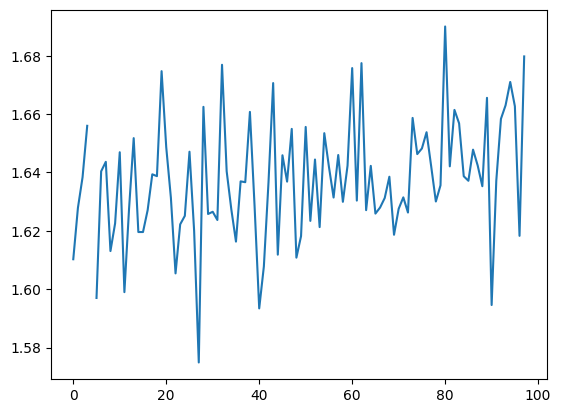

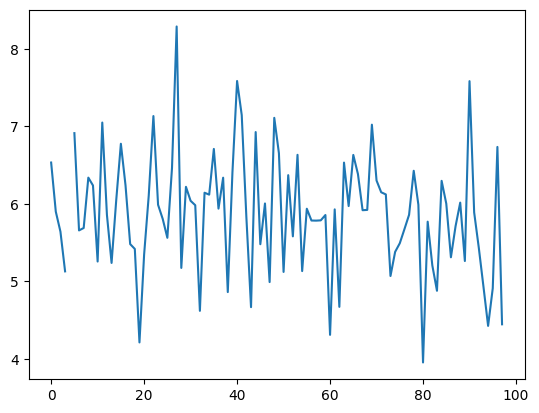

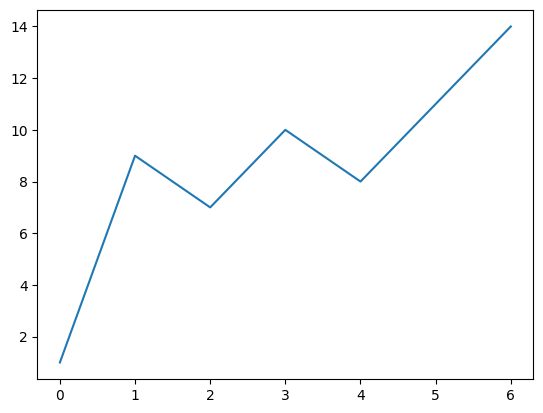

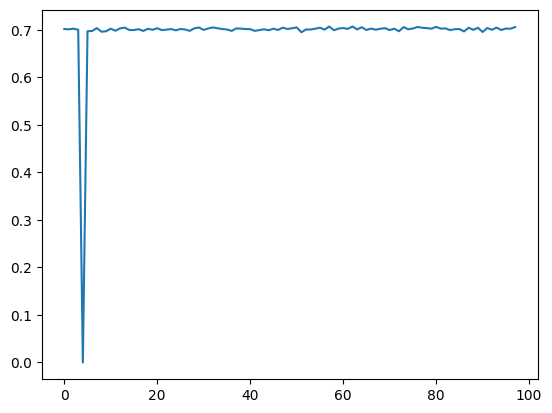

63

In [2]:
plt.plot(total_avg_verification)
plt.show()
plt.plot(np.array(total_latency))
plt.show()

plt.plot(framecnt_total)
plt.show()

plt.plot(goodput_total)
plt.show()

goodput_total = np.array(goodput_total)

open('results.txt', 'a+').write(f"goodput: {np.average(goodput_total)}, without zero: {np.average(goodput_total[goodput_total != 0])} \n")

In [3]:
print(np.average(goodput_total[goodput_total != 0]), np.average(goodput_total))

x = latency[latency != 0]+offset
print(np.average(x))

0.7014526469694568 0.6942949668983398
-0.005978059768676758
